Scarano Gianmarco - Matricola Code: 2047315

# Import needed libraries

### Google Colab compatibility
Run this next cell only if you're using Google Colab!

In [ ]:
# Library for downloading files from GoogleDrive. It will be used for downloading the LEGO Dataset.
!pip install -U gdown efficientnet wandb --quiet  

### Continuing the imports

In [1]:
# We set the global variable for Google Colab, so we can assign paths, etc. accordingly
try:
  import google.colab
  RunningInCOLAB = True
except:
  RunningInCOLAB = False

In [1]:
import multiprocessing
import os
import random
import shutil

import efficientnet.keras as efn
import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import activations, losses, optimizers, regularizers
from keras.layers import (Activation, AveragePooling2D, BatchNormalization,
                          Conv2D, Dense, Dropout, Flatten,
                          GlobalAveragePooling2D, Input, MaxPooling2D)
from keras.models import Model, Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
from keras.utils.layer_utils import count_params
from PIL import Image, ImageOps
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from tqdm import tqdm
from wandb.keras import WandbCallback, WandbModelCheckpoint

import wandb

In [3]:
print("Tensorflow version %s" %tf.__version__)
print("tf.Keras version %s" %tf.keras.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.10.1
tf.Keras version 2.10.0
Found GPU at: /device:GPU:0


# WANDB Support

In [4]:
print(F"W&B version: {wandb.__version__}")
wandb.login()

W&B version: 0.13.7


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: slimshadys. Use `wandb login --relogin` to force relogin


True

# Helper functions

Delete Artifacts

In [5]:
"""
This method delete useless models from the WANDB servers,
after passing the run_id parameter.

With useless models, we mean all the models saved up
to epoch n and all the best models saved up to epoch n.

:param run_id: It's the ID of the run (13qvc9uo, 83cvs1ff, etc.)
:param entity: The entity for the WANDB project
:param project_name: The name of the WANDB project

:return: Delete Artifacts and returns
""" 
def deleteArtifacts(run_id='None', entity='None', project_name='None'):
    
    if run_id == 'None' or entity == 'None' or project_name == 'None':
        raise NotImplementedError("Check parameters! You should provide a run_ID, an entity name and a project name!")
    
    modelList = []
    runModelList = []
    runValList = []
    maxModel = 0
    maxRunVal = 0
    maxRunModel = 0
    c = 0

    # Get the instance of the given run_id.
    run = wandb.Api().run(F"{entity}/{project_name}/{run_id}")
    
    print(F"Trying to delete useless artifacts from run ID: '{run_id}' ..")
    
    # We loop through the artifacts of the given run_id.
    # We want to delete artifacts which start with
    # - "model-"
    # - "run_{run_id}_model"
    # - "run-{run_id}-validation"
    #
    # There might be some more names while looping through the artifacts,
    # but our runs just save these "aliases".
    for artifact_version in run.logged_artifacts():
        if(artifact_version.name.startswith("model-")):
            modelList.append([artifact_version.name, (artifact_version.name.split(":")[1]).replace("v","")])
        elif(artifact_version.name.startswith(F"run_{run_id}_model")):
            runModelList.append([artifact_version.name, (artifact_version.name.split(":")[1]).replace("v","")])
        elif artifact_version.name.startswith(F"run-{run_id}-validation"):
            runValList.append([artifact_version.name, (artifact_version.name.split(":")[1]).replace("v","")])
        else:
            raise NotImplementedError("Unexpected artifact name!")

    # Check if there
    if(len(modelList) > 0):
        maxModel = max(int(l[1]) for l in modelList)
        
    if(len(runModelList) > 0):        
        maxRunModel = max(int(l[1]) for l in runModelList)
    
    if(len(runValList) > 0):
        maxRunVal = max(int(l[1]) for l in runValList)
        
    # Actual deleting iteration. We loop once again and
    # we delete all models up to maxModel / maxRunModel, etc.
    if(not (maxRunModel == 0 and maxModel == 0)):
        for artifact_version in run.logged_artifacts():
            if artifact_version.name.startswith("model-"):
                nModel = (artifact_version.name.split(":")[1]).replace("v","")
                if(int(nModel) < maxModel):
                    artifact_version.delete(delete_aliases=True)
                    c += 1 
            elif artifact_version.name.startswith(F"run_{run_id}_model"):
                runModel = (artifact_version.name.split(":")[1]).replace("v","")
                if(int(runModel) < maxRunModel):
                    artifact_version.delete(delete_aliases=True)
                    c += 1
            elif artifact_version.name.startswith(F"run-{run_id}-validation"):
                # We leave the validation artifacts for now.
                # We save them into an array, but we do not touch them.
                continue
            else:
                raise NotImplementedError("Does this artifact exist?")
            
        print(F"Successfully deleted {str(c)} useless artifacts from {run_id}!")
    else:
        print("There was nothing to delete.")
        print(F"N. of model-: {maxModel}")
        print(F"N. of run_{run_id}_model: {maxRunModel}")
        print(F"N. of run-{run_id}-validation: {maxRunVal}")
    wandb.finish()
    return

Config changer in real-time

In [6]:
"""
This method edits a configuration parameter given a run_id.

:param run_id: It's the ID of the run (13qvc9uo, 83cvs1ff, etc.)
:param entity: The entity for the WANDB project
:param project_name: The name of the WANDB project
:param parameter: The name of the parameter to change
:param newValue: The value to give to the parameter passed above

:return: Edit the needed parameter and returns
""" 
def configChanger(run_id='None', entity='None', project_name='None', parameter='None', newValue = 'None'):
    
    if run_id == 'None' or entity == 'None' or project_name == 'None' or parameter == 'None' or newValue == 'None':
        raise NotImplementedError("Check parameters! You should provide:\n- run_ID\n- Entity name\n- Project name\n- Parameter\n- New Value")
      
    run = wandb.Api().run(F"{entity}/{project_name}/{run_id}")
    
    # EXAMPLE: We edit the model_name parameter 
    run.config[parameter] = newValue

    run.update()
    return

Resuming a run and a checkpoint for continuing the training phase

In [7]:
"""
This method resumes a run and a model for continuing training.

:param project_name: The name of the WANDB project
:param entity_name: The entity for the WANDB project
:param run_id: It's the ID of the run (13qvc9uo, 83cvs1ff, etc.)
:param version: Version for that specific model (v10, v25, etc.)
:param configRun: Config for that run

:return: Resumes the run and the model and returns
""" 
def resumeTraining(project_name='None', entity_name='None', run_id='None', version='None', configRun=None):
    
    if run_id == 'None' or entity_name == 'None' or project_name == 'None' or version == 'None' or configRun == None:
        raise NotImplementedError("Check parameters! You should provide: \
                                  \n- run_ID \
                                  \n- Entity name \
                                  \n- Project name \
                                  \n- Version (of the model) \
                                  \n- configRun (configurations)")

    ## RESUMING A RUN AND A MODEL FOR CONTINUING EPOCHS
    wandb.finish()
    run = wandb.init(project = project_name, 
                     entity = entity_name,
                     id = run_id,
                     job_type = 'train',
                     resume = True,
    )

    artifact = run.use_artifact(F'{entity_name}/{project_name}/run_{run_id}:{version}', type='model')
    artifact_dir = artifact.download()
    if(RunningInCOLAB):
        model = load_model(F"artifacts/run_{run_id}_model:{version}/files\\model-{configRun['model_name']}-{configRun['epochs']}.h5")
    else:
        model = load_model(F"artifacts/run_{run_id}_model-{version}/files/model-{configRun['model_name']}-{configRun['epochs']}.h5")
    
    return model, run

Resuming a run and retrieve the best model

In [8]:
"""
This method resumes a run and retrieves the best model for that run.

:param project_name: The name of the WANDB project
:param entity_name: The entity for the WANDB project
:param run_id: It's the ID of the run (13qvc9uo, 83cvs1ff, etc.)

:return: Resumes the run and the best model and returns it
""" 
def resumeBestModel(project_name='None', entity_name='None', run_id='None'):
    
    if run_id == 'None' or entity_name == 'None' or project_name == 'None':
        raise NotImplementedError("Check parameters! You should provide: \
                                    \n- run_ID \
                                    \n- Entity name \
                                    \n- Project name")
    wandb.finish()
    
    run = wandb.init(project = project_name, 
                        entity = entity_name,
                        id = run_id,
                        job_type = 'train',
                        resume = True,
    )

    best_model = wandb.restore('model-best.h5', run_path=F"{entity_name}/{project_name}/{run_id}")
    model = load_model(best_model.name)
    model.summary()
        
    wandb.finish()

    return model

# Downloading the dataset

In [2]:
# We use the library gdown in order to download our LEGODataset from Google Drive.
# If downloadDataset = True, it will first clean up the directories and start downloading the dataset
# If downloadDataset = False, assumes that the dataset has already been downloaded
downloadDataset = True
datasetDirectory = "LEGODataset/"

if downloadDataset:
    try:
        shutil.rmtree(os.path.join(datasetDirectory))
        os.remove("LEGODataset.zip")
    except:
        print("Probably the dataset has already been cleaned up.")
        print("Re-downloading ...")

    LEGO_Dataset_URL = 'https://drive.google.com/uc?id=' + '1b7WubxZUj0n-OQC6qb0r-iqZrHAiFu1T' + '&export=download&confirm=t' 
    gdown.download(LEGO_Dataset_URL, 'LEGODataset.zip', quiet=False)
    print("\nExtracting dataset...")
    shutil.unpack_archive("LEGODataset.zip", datasetDirectory)

    # Cleaning files
    print("\nCleaning files ...")

    os.remove("LEGODataset.zip")
    shutil.rmtree(os.path.join(datasetDirectory,"Collada models"))
    shutil.rmtree(os.path.join(datasetDirectory,"LEGO brick images v1"))
else:
    print("Dataset already downloaded.\nIf you want to re-download it, set the 'downloadDataset' variable to True!")

Probably the dataset has already been cleaned up.
Re-downloading ...


Downloading...
From: https://drive.google.com/uc?id=1b7WubxZUj0n-OQC6qb0r-iqZrHAiFu1T&export=download&confirm=t
To: c:\Users\Gianmarco\Documents\Git\MachineLearning\test\Homeworks\2. Image Classification\LEGODataset.zip
100%|██████████| 1.07G/1.07G [03:25<00:00, 5.22MB/s]



Extracting dataset...

Cleaning files ...


# Transferring our Dataset into a Pandas DataFrame

## Entire Dataset

In [3]:
# We enter the dataset directory and for every picture we store:
# - 'Image'  = Actual RGB image (400 x 400) as a PIL object
# - 'Path'   = Path for that specific Image
# - 'ID'     = ID of the brick for that specific Image (080L, 080R, etc.)
# - 'Name'   = Name of the brick for that specific Image (flat tile corner 2x2, etc.)
# - 'Class'  = Class of the brick for that specific Image (14719, 15672, 18654)
images = os.listdir(os.path.join(datasetDirectory,"dataset"))

rows_list = []
dict = {}

for img in images:
    brick = img.split(" ")
    
    brickID = brick[-1].split(".")[0]
    brickClass = brick[0]
    brickName = " ".join(brick[1:-1])
    
    dict = {}
    dict.update([('Path', os.path.join(datasetDirectory,"dataset", img)),('ID', brickID), ('Name', brickName), ('Class', brickClass)]) 
    rows_list.append(dict)
    
df = pd.DataFrame(rows_list)

## Validation

In [4]:
# We enter the dataset directory and for every picture in the validation text file we store:
# - 'Image'  = Actual RGB image (400 x 400) as a PIL object
# - 'Path'   = Path for that specific Image
# - 'ID'     = ID of the brick for that specific Image (080L, 080R, etc.)
# - 'Name'   = Name of the brick for that specific Image (flat tile corner 2x2, etc.)
# - 'Class'  = Class of the brick for that specific Image (14719, 15672, 18654)
#
# TODO: We can simply extract the images directly from the DataFrame "df".
rows_list = []
dict = {}
rawData = pd.read_csv(os.path.join(datasetDirectory,"validation.txt"), index_col=False, header=None)

for index, row in rawData.iterrows():

    brick = row[0].split(" ")
    
    brickID = brick[-1].split(".")[0]
    brickClass = brick[0]
    brickName = " ".join(brick[1:-1])
    
    dict = {}
    dict.update([('Path', os.path.join(datasetDirectory,"dataset", row[0])), ('ID', brickID), ('Name', brickName), ('Class', brickClass)]) 
    rows_list.append(dict)
    
dfValidation = pd.DataFrame(rows_list)

## Train

In [5]:
# We retrieve the Train dataFrame by simply removing the validation set from the entire set.
dfTrain = pd.concat([df,dfValidation], axis=0, ignore_index=True).drop_duplicates(subset=["ID","Name","Class"],keep=False, ignore_index=True)

## WANB Table for Training/Test set<br>
This process takes around 30 mins, since it has to store them into the WANDB server.

In [ ]:
# Initialize a new W&B run
run = wandb.init(
    project="ML - Homework 2", 
    entity="slimshadys"
)

trainLen = len(dfTrain)    # 3200
valLen = len(dfValidation) # 800

# Intialize a W&B Artifacts
ds = wandb.Artifact("LEGODataset", "dataset")

# Initialize an empty table
columns=["Image", "Path", "ID", "Name", "Class"]
train_table = wandb.Table(columns=columns)
validation_table = wandb.Table(columns=columns)

print(F"Need to fetch {trainLen} training images..")
for index, row in tqdm(dfTrain.iterrows()):
    if (index >= trainLen):
        break
    train_table.add_data(wandb.Image(row['Image']), row['Path'], row['ID'], row['Name'], row['Class'])
print("--------------------------------------")

print(F"Need to fetch {valLen} validation images..")
for index, row in tqdm(dfValidation.iterrows()):
    if (index >= valLen):
        break
    validation_table.add_data(wandb.Image(row['Image']), row['Path'], row['ID'], row['Name'], row['Class'])
print("--------------------------------------")

# Add the table to the Artifact
ds['Train_data'] = train_table
ds['Validation_data'] = validation_table

# Save the dataset as an Artifact
ds.save()

wandb.log({'Train_data': train_table})
wandb.log({'Validation_data': validation_table})

# Finish the run
run.finish()

# Creating DataLoaders

## Define the parameters of the training phase

In [94]:
def resetDefaultConfigs():
    _ = {}
    _.update([
        ('data_flag', 'LEGODataset'),
        ('batch_size', 32),
        ('pretrain_weights', 'imagenet'),
        ('epochs', 50),
        ('init_learning_rate', 0.001),
        ('lr_decay_rate', 0.1),
        ('optimizer', 'adam'),
        ('model_name', ''),
        ('loss_fn', 'categorical_crossentropy'),
        ('metrics', ["accuracy"]),
        ('patience', 5),
        ('dataAugmentation', 1)
    ])
    return _
    
configs = resetDefaultConfigs()

## Data augmentation / pre-processing

In [95]:
def getDataGenerator(value):
    if(value == 0):
        return ImageDataGenerator(
            rescale = 1. / 255
        )
    elif(value == 1):
        return ImageDataGenerator(
            rescale = 1. / 255,\
            zoom_range = 0.1,\
            rotation_range = 5
        )
    elif (value == 2):
        return ImageDataGenerator(
            rescale = 1. / 255,\
            zoom_range = 0.1,\
            rotation_range = 40, \
            horizontal_flip = 0.3, \
            width_shift_range=0.2, \
            height_shift_range=0.1, \
            vertical_flip = 0.2
    )
    else:
        raise NotImplementedError("Please specify a input value for transformations!\n \
                                  Use:\n \
                                    \t- value = 0 (Low image pre-processing)\n \
                                    \t- value = 1 (Mid image pre-processing)\n \
                                    \t- value = 2 (High image pre-processing)")

## Loaders

In [96]:
# 0 = Low pre-processing    (Rescaling)
# 1 = Mid pre-processing    (Rescaling, Zoom range, Rotation range)
# 2 = High pre-processing   (Rescaling, Zoom range, Rotation range, Horizontal Flip, Width shift range, Height shift range, Vertical flip)
data_generator = getDataGenerator(configs['dataAugmentation'])

# Create a train loader using the data from our Train DataFrame
train_loader = data_generator.flow_from_dataframe(
    dataframe = dfTrain,                # DataFrame containing the training data
    x_col = "Path",                     # Column containing the absolute paths to the images
    y_col = "Class",                    # Column containing the class labels for the images
    color_mode = "rgb",                 # We can specify "greyscale" for 1 channel / "rgb" for 3 channels
    class_mode = "categorical",         # We want a 2D numpy array of one-hot encoded labels
    target_size = (200, 200),           # The size of the images. Here we resize our images from (400,400) to (200,200)
    batch_size = configs['batch_size'], # Batch size
    shuffle = True,                     # We shuffle the train data before generating batches
)

# For the validation set, we just rescale the single pixels of the images between 0 and 1.
test_datagen = ImageDataGenerator(
    rescale = 1. / 255)

# create a train loader using the data from the DataFrame
validation_loader = test_datagen.flow_from_dataframe(
    dataframe = dfValidation,           # DataFrame containing the validation data
    x_col = "Path",                     # Column containing the absolute paths to the images
    y_col = "Class",                    # Column containing the class labels for the images
    color_mode = "rgb",                 # We can specify "greyscale" for 1 channel / "rgb" for 3 channels
    class_mode = "categorical",         # We want a 2D numpy array of one-hot encoded labels
    target_size = (200, 200),           # The size of the images. Here we resize our images from (400,400) to (200,200)
    batch_size = configs['batch_size'], # Batch size
    shuffle = False,                    # We don't want to shuffle the validation data before generating batches
)

num_samples = train_loader.n
num_classes = len(train_loader.class_indices)
input_shape = train_loader.image_shape

classnames = [k for k,v in train_loader.class_indices.items()]

print("------------------------------------")
print(F"Image size: {str(input_shape)}")
print(F"Number of samples: {num_samples}")
print(F"Number of classes: {num_classes}")
print(F"Classes: {classnames}")

Found 32000 validated image filenames belonging to 50 classes.
Found 8000 validated image filenames belonging to 50 classes.
------------------------------------
Image size: (200, 200, 3)
Number of samples: 32000
Number of classes: 50
Classes: ['14719', '15672', '18654', '2357', '2420', '2780', '27925', '3001', '3002', '3003', '3004', '3005', '3010', '3020', '3021', '3022', '3023', '3024', '3037', '3038', '3039', '3040', '3045', '3046', '3062', '3063', '3068', '3069', '3070', '3298', '33909', '3622', '3623', '3659', '3675', '3700', '3794', '4150', '41677', '41678', '4274', '4286', '43093', '43857', '4490', '54200', '6143', '6632', '85984', '99301']


## Show a simple example

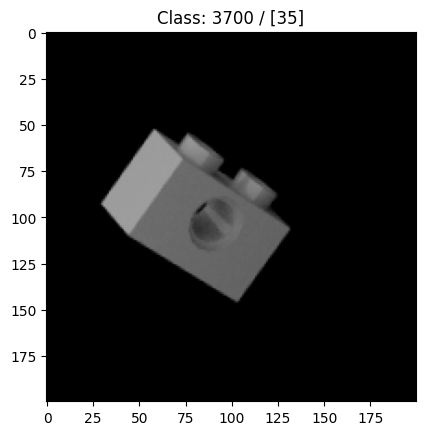

In [16]:
x,y = train_loader.next()

image = x[0]
label = y[0].argmax()  # categorical from one-hot-encoding
plt.title(F"Class: {classnames[label]} / [{label}]")
plt.imshow(image)
plt.show()

## WANB Table for Augmented Images in the training set<br>
This process takes around 30 mins, since it has to store them into the WANDB server.

In [97]:
# Initialize a new W&B run
run = wandb.init(project="ML - Homework 2", 
                    entity="slimshadys",
                    id = '1d47fkou',
                    resume = True,
)

# Use the already logged dataset
x, y = next(train_loader)
images = (dfTrain['Image'][train_loader.index_array])[:32]
names = (dfTrain['Name'][train_loader.index_array])[:32]
classes = (dfTrain['Class'][train_loader.index_array])[:32]

# Create augmentation table
augment_table = wandb.Table(columns=['Image', 'Augmented', 'Name', 'Class'])

# Get augmented images and log it onto the table
for img, x_, name, label in zip(images, x, names, classes):
    augment_table.add_data(wandb.Image(img),
                           wandb.Image(x_),
                           name,
                           label,
    )

# Log the table
wandb.log({'Augmented_data_v2': augment_table})

# Finish the run
run.finish()

# Models

In [ ]:
# Let's define some global variables needed for all the models

# - Input Tensor
input0 = Input(shape=input_shape)

## MobileNetV2

In [27]:
# Here we can define which layers can be trainable, plus we can define
# the output layer from which we can get the features.
trainable_layers = [""]
output_layer_name = [""]

# Load MobileNetV2
mobilenetV2 = tf.keras.applications.MobileNetV2(include_top=False, 
                                                weights=configs['pretrain_weights'], 
                                                input_shape=input_shape,
                                                input_tensor=input0)

feature_extractor = tf.keras.models.Model(inputs=input0, 
                                          outputs=mobilenetV2.output, 
                                          name="mobilenetV2_features")

#set the feture extractor layers as non-trainable
for idx,layer in enumerate(feature_extractor.layers):
  if layer.name in trainable_layers:
    layer.trainable = True
  else:
    layer.trainable = False

# Get the output tensor from a layer of the feature extractor
output_extractor = feature_extractor.output
#output_extractor = feature_extractor.get_layer(name = output_layer_name).output

flatten = Flatten()(output_extractor) # Flatten the output of a Conv layer
flatten_norm = BatchNormalization()(flatten) # Apply BatchNormalization()

dense2 = Dropout(0.2)(flatten_norm) # Apply Dropout() to the BatchNormalized Flatten layer

# Add a Dense layer + Batch Normalization + ReLU
dense2 = Dense(100)(dense2)
dense2 = BatchNormalization()(dense2)
dense2 = Activation("relu")(dense2)

# Add a Dense layer + Batch Normalization + SoftMax
dense3 = Dense(num_classes)(dense2)
dense3 = BatchNormalization()(dense3)
dense3 = Activation("softmax")(dense3)

model = tf.keras.models.Model(inputs=input0, outputs=dense3, name="MobileNetV2")

model.summary()

configs['model_name'] = model.name

Model: "MobileNetV2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 100, 100, 32  864         ['input_14[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 100, 100, 32  128         ['Conv1[0][0]']                  
                                )                                                       

## MobileNetV3Small

In [ ]:
# Here we can define which layers can be trainable, plus we can define
# the output layer from which we can get the features.
trainable_layers = [""]
output_layer_name = [""]

# Load MobileNetV3Small
mobileNetV3Small = tf.keras.applications.MobileNetV3Small(include_top=False, 
                                                          weights=configs['pretrain_weights'], 
                                                          input_shape=input_shape,
                                                          input_tensor=input0)

feature_extractor = tf.keras.models.Model(inputs=input0, 
                                          outputs=mobileNetV3Small.output, 
                                          name="MobileNetV3Small_features")

#set the feture extractor layers as non-trainable
for idx,layer in enumerate(feature_extractor.layers):
  if layer.name in trainable_layers:
    layer.trainable = True
  else:
    layer.trainable = False

# get the output tensor from a layer of the feature extractor
output_extractor = feature_extractor.output
#output_extractor = feature_extractor.get_layer(name = output_layer_name).output

# flat the output of a Conv layer
flatten = Flatten()(output_extractor) 
flatten_norm = BatchNormalization()(flatten)

dense2 = Dropout(0.2)(flatten_norm)

# add a Dense layer
dense2 = Dense(100)(dense2)
dense2 = BatchNormalization()(dense2)
dense2 = Activation("relu")(dense2)

# add the final output layer
dense3 = Dense(num_classes)(dense2)
dense3 = BatchNormalization()(dense3)
dense3 = Activation("softmax")(dense3)

model = tf.keras.models.Model(inputs=input0, outputs=dense3, name="MobileNetV3Small")

model.summary()

configs['model_name'] = model.name

## Xception
XCeption needs the Nesterov optimizer, as per its paper.<br><br> - optimizer = optimizers.SGD(learning_rate=config['init_learning_rate'], nesterov=True))

In [16]:
# Here we can define which layers can be trainable, plus we can define
# the output layer from which we can get the features.
trainable_layers = [""]
output_layer_name = [""]
    
# Load Xception model
xceptionModel = tf.keras.applications.xception.Xception(include_top=False, 
                                                            classes=num_classes, 
                                                            weights=configs['pretrain_weights'],
                                                            input_shape=input_shape, 
                                                            input_tensor=input0)

feature_extractor = tf.keras.models.Model(inputs=input0, outputs=xceptionModel.output, name="Xception_features")
feature_extractor.trainable=True

# get the output tensor from a layer of the feature extractor
#output_extractor = feature_extractor.get_layer(name = output_layer_name).output
output_extractor = feature_extractor.output

# flat the output of a Conv layer
flatten = Flatten()(output_extractor)
flatten_norm = BatchNormalization()(flatten)

# add a Dense layer
dense2 = Dense(100)(flatten_norm)
dense2 = Activation("relu")(dense2)

# add the final output layer
dense3 = Dense(num_classes)(dense2)
dense3 = Activation("softmax")(dense3)

model = tf.keras.models.Model(inputs=input0, outputs=dense3, name="Xception")

model.summary()
configs['model_name'] = model.name

83683744/83683744 [==============================] - 1s 0us/step


## VGG19

In [37]:
# Here we can define which layers can be trainable, plus we can define
# the output layer from which we can get the features.
trainable_layers = ["block5_conv3"]
output_layer_name = ["block5_pool"]

# Load VGG19 model
VGG19Model = tf.keras.applications.vgg19.VGG19(include_top=False, 
                                                weights=configs['pretrain_weights'],
                                                input_shape=input_shape,
                                                input_tensor=input0)

feature_extractor = tf.keras.models.Model(inputs=input0, 
                                          outputs=VGG19Model.output, 
                                          name="VGG19_features")

# set the feture extractor layers as non-trainable
for idx,layer in enumerate(feature_extractor.layers):
  if layer.name in trainable_layers:
    layer.trainable = True
  else:
    layer.trainable = False

# get the output tensor from a layer of the feature extractor
output_extractor = feature_extractor.get_layer(name = output_layer_name).output

output_extractor = MaxPooling2D(pool_size=(4,4))(output_extractor)

# flat the output of a Conv layer
flatten = Flatten()(output_extractor) 
flatten_norm = BatchNormalization()(flatten)

dense2 = Dropout(0.2)(flatten_norm)

# add a Dense layer
dense2 = Dense(100)(dense2)
dense2 = BatchNormalization()(dense2)
dense2 = tf.keras.activations.relu(dense2)
dense2 = Activation("relu")(dense2)

# add the final output layer
dense3 = Dense(num_classes)(dense2)
dense3 = BatchNormalization()(dense3)
dense3 = Activation("softmax")(dense3)

model = tf.keras.models.Model(inputs=input0, outputs=dense3, name="VGG19")

model.summary()

configs['model_name'] = model.name

Model: "vgg16_features"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)    

## VGG16
Best model in this notebook:
- Acc  = 0.9135
- Loss = 0.2939

In [27]:
# Here we can define which layers can be trainable, plus we can define
# the output layer from which we can get the features.
trainable_layers = ["block5_conv3"]
output_layer_name = "block5_pool"

# Load VGG16 model
VGG16Model = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                weights=configs['pretrain_weights'], 
                                                input_shape=input_shape,
                                                input_tensor=input0)

feature_extractor = tf.keras.models.Model(inputs=input0, 
                                          outputs=VGG16Model.output, 
                                          name="VGG16_Features")

# Set the feature extractor layers as non-trainable
for idx, layer in enumerate(feature_extractor.layers):
  if layer.name in trainable_layers:
    layer.trainable = True
  else:
    layer.trainable = False

# Get the output tensor from a layer of the feature extractor
output_extractor = feature_extractor.get_layer(name = output_layer_name).output

output_extractor = AveragePooling2D(pool_size=(4,4))(output_extractor)

# flat the output of a Conv layer
flatten = Flatten()(output_extractor) 
flatten_norm = BatchNormalization()(flatten)

dense2 = Dropout(0.2)(flatten_norm)

# add a Dense layer
dense2 = Dense(100)(dense2)
dense2 = BatchNormalization()(dense2)
dense2 = Activation("relu")(dense2)

# add the final output layer
dense3 = Dense(num_classes)(dense2)
dense3 = BatchNormalization()(dense3)
dense3 = Activation("softmax")(dense3)

model = tf.keras.models.Model(inputs=input0, outputs=dense3, name="VGG16")

# build the transfer model
model.summary()

configs['model_name'] = model.name

Model: "VGG16Edited"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       

## ResNet50

In [28]:
# Here we can define which layers can be trainable, plus we can define
# the output layer from which we can get the features.
trainable_layers = [""]
output_layer_name = [""]

# Load EfficientNet B7
resNet50 = tf.keras.applications.resnet.ResNet50(include_top=False, 
                                                    classes=num_classes, 
                                                    weights=configs['pretrain_weights'],
                                                    input_shape=input_shape,
                                                    input_tensor=input0)

feature_extractor = tf.keras.models.Model(inputs=input0, 
                                            outputs=resNet50.output, 
                                            name="ResNet50_features")
#set the feture extractor layers as non-trainable
for idx,layer in enumerate(feature_extractor.layers):
    if layer.name in trainable_layers:
        layer.trainable = True
    else:
        layer.trainable = False

# get the output tensor from a layer of the feature extractor
output_extractor = feature_extractor.output
#output_extractor = feature_extractor.get_layer(name = output_layer_name).output

# flat the output of a Conv layer
flatten = Flatten()(output_extractor)
flatten_norm = BatchNormalization()(flatten)

# add a Dense layer
dense2 = Dense(100)(flatten_norm)
dense2 = Activation("relu")(dense2)

# add the final output layer
dense3 = Dense(num_classes)(dense2)
dense3 = Activation("softmax")(dense3)

model = tf.keras.models.Model(inputs=input0, outputs=dense3, name="ResNet50")

model.summary()

configs['model_name'] = model.name

Model: "ResNet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

## EfficientNet-L2


In [ ]:
# Here batch size must be <= 8 otherwise you will encounter OOM issues (even on Colab)
#
# PARAMETERS WITH THE ENTIRE ARCHITECTURE:
# - Total params: 502,869,746
# - Trainable params: 26,974,750
# - Non-trainable params: 475,894,996
#
# PARAMETERS UNTIL THE 3RD BLOCK: 
# - Total params: 18,157,050
# - Trainable params: 11,005,150
# - Non-trainable params: 7,151,900
# ===========================================================
#
# The initialization of the model has been stopped at the 3rd block, 
# since it will take around 30 minutes for a single epoch if we consider
# the whole EfficientNet-L2 architecture.
#
# ===========================================================
#
# Epoch 1 = loss: 3.9122 - accuracy: 0.0200 -> Time: 12 min
# Epoch 2 = loss: 3.9124 - accuracy: 0.0201 -> Time: 12 min
#
# This is not good for our testing, but this was done to demonstrate that such big
# models can be loaded and trained without problems with our LEGO Dataset. 
# It is not computationally great, though.
    
trainable_layers = [""]
output_layer_name = "block3k_project_bn"

efficientNetL2 = efn.EfficientNetL2(weights="./efficientnet-l2_noisy-student_notop.h5", 
                            input_shape=input_shape, 
                            include_top=False, 
                            drop_connect_rate=0)

feature_extractor = tf.keras.models.Model(inputs=efficientNetL2.input, 
                                            outputs=efficientNetL2.output, 
                                            name="EfficientNetL2_features")

# Set the feature extractor layers as non-trainable
for idx, layer in enumerate(feature_extractor.layers):
    if layer.name in trainable_layers:
        layer.trainable = True
    else:
        layer.trainable = False
        
# get the output tensor from a layer of the feature extractor
output_extractor = feature_extractor.get_layer(name = output_layer_name).output
#output_extractor = feature_extractor.output

# flat the output of a Conv layer
flatten = Flatten()(output_extractor) 

dense2 = Dropout(0.2)(flatten)

# add a Dense layer
dense2 = Dense(100)(dense2)
dense2 = Activation("relu")(dense2)

# add the final output layer
dense3 = Dense(num_classes)(dense2)
dense3 = Activation("softmax")(dense3)

model = tf.keras.models.Model(inputs=feature_extractor.input, outputs=dense3, name="EfficientNet-L2")

print(F"Number of trainable parameters: {count_params(model.trainable_weights)}")
print(F"Number of non trainable parameters: {count_params(model.non_trainable_weights)}")

configs['model_name'] = model.name

## LEGO Model (Personal)

In [14]:
# ---------------------- BLOCK 1  ----------------------
# We use a Conv2D layer with a Kernel size of 4x4 and stride (1,1).
# We use padding as 'same', meaning that the output size will be the same as the input.
# ReLU is the activation function of the Conv2D.
x = Conv2D(16, kernel_size=(4, 4), strides=(1, 1), activation='relu', padding='same', name="Conv2D_1")(input0)
x = BatchNormalization()(x) # Batch normalization on the Conv2D.
# AVG Pooling with a Pool Size of (2, 2). We use padding 'valid', meaning that our output shape will be of: 100 x 100 x 16
x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name="AVG_Pooling_1")(x) 

# ---------------------- BLOCK 2  ----------------------
x = Conv2D(32, kernel_size=(4, 4), strides=(1, 1), activation='relu', padding='same', name="Conv2D_2")(x) # 100 x 100 x 32
x = BatchNormalization()(x)
x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name="AVG_Pooling_2")(x)          # 50 x 50 x 32

# ---------------------- BLOCK 3  ----------------------
x = Conv2D(64, kernel_size=(4, 4), strides=(1, 1), activation='relu', padding='same', name="Conv2D_3")(x) # 50 x 50 x 64
x = BatchNormalization()(x)
x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name="AVG_Pooling_3")(x)          # 25 x 25 x 64

# ----------------- STARTING DENSE LAYERS  -----------------

x = Flatten()(x) # We flatten the previous AveragePooling Layer

# We instantiate a Fully Connected Layer (Dense) with 2048 units and ReLU on top.
# After that, we simply apply a BatchNormalization() and a Dropout Layer with value 0.2
# Dropout rate is very low, otherwise the validation accuracy would be higher than training
# (Due to the fact that while in evaluate mode, the Dropout Layer gets de-activated)
dense1 = Dense(2048, name="Dense_Layer_2048", activation='relu')(x)    
dense1 = BatchNormalization()(dense1)
dense1 = Dropout(0.2)(dense1)

# We then apply another FC Layer with 1024 units
dense2 = Dense(1024, name="Dense_Layer_1024", activation='relu')(dense1)

# Lastly, we build the last FC Layer with 50 units (classes)
# We then apply a simple SoftMax activation function on top.
dense3 = Dense(num_classes, activation="softmax", name="Dense_Layer_50_OUT")(dense2)

model = tf.keras.models.Model(inputs=input0, outputs=dense3, name="LEGOModel")

model.summary()

configs.update([
    ('model_name', model.name),
    ('pretrain_weights', 'None')
])

Model: "LEGOModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 Conv2D_1 (Conv2D)           (None, 200, 200, 16)      784       
                                                                 
 batch_normalization (BatchN  (None, 200, 200, 16)     64        
 ormalization)                                                   
                                                                 
 AVG_Pooling_1 (AveragePooli  (None, 100, 100, 16)     0         
 ng2D)                                                           
                                                                 
 Conv2D_2 (Conv2D)           (None, 100, 100, 32)      8224      
                                                                 
 batch_normalization_1 (Batc  (None, 100, 100, 32)     12

# Fit the model

In [ ]:
initial_epoch = 0

Resuming Training

In [ ]:
# ========= RESUMING TRAINING =========

# Update configs here
configRun = [['model_name', 'LEGOModel'], ['epochs', 15]]

run, model = resumeTraining(project_name='None', entity_name='None', run_id='None', version='None', configRun=configRun)

model.summary()
configs = run.config

configs['model_name'] = model.name
configs['pretrain_weights'] = 'None'
configs['init_learning_rate'] = run.config['learning_rate']

initial_epoch = configRun['epochs']

New training from scratch

In [ ]:
run = wandb.init(
    project="ML - Homework 2", 
    entity="slimshadys",
    config=configs,
    job_type='train',
)

In [28]:
def lr_scheduler(epoch, lr):
    # log the current learning rate onto W&B
    if wandb.run is None:
        raise wandb.Error("You must call wandb.init() before WandbCallback()")

    wandb.log({'learning_rate': lr}, commit=False)
    
    if epoch < 8:
        return lr
    else:
        return lr * tf.math.exp(-configs['lr_decay_rate'])

In [29]:
def delete_epochs(epoch,logs):
    for file in os.listdir(wandb.run.dir):
        if(file.startswith(F"model-{model.name}-" + F'{epoch-1:02d}') and file.endswith(".h5")):
            os.remove(os.path.join(wandb.run.dir, file))
    return

In [30]:
# Arguments for the fit() function
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=configs['patience'])
deleteEpochs = tf.keras.callbacks.LambdaCallback(on_epoch_begin=delete_epochs)

# Define WandbCallback for experiment tracking
model_checkpoint = WandbModelCheckpoint(monitor='val_accuracy',
    filepath = wandb.run.dir + '\\' + F'model-{model.name}' + '-{epoch:02d}.h5',
    save_best_only=False,
    save_freq='epoch')

wandb_callback = WandbCallback(monitor='val_accuracy',
                               log_weights=True,
                               log_evaluation=True,
                               save_model=True,
                               validation_steps=5)
workers = multiprocessing.cpu_count()

In [31]:
def train(config: dict, 
          callbacks: list,
          verbose: int=2):
    
    tf.keras.backend.clear_session()
    
    # Arguments for the compile() function
    optimizer = optimizers.Adam(learning_rate=config['init_learning_rate'])
    wandb.config['optimizer'] = "adam"

    model.compile(
        optimizer = optimizer, 
        loss = config['loss_fn'], 
        metrics = config['metrics']
    )
    
    try:
        h = model.fit(train_loader, epochs=config['epochs'], 
                      use_multiprocessing = False,
                      initial_epoch = initial_epoch, workers=workers, 
                      verbose=verbose, callbacks=callbacks, 
                      validation_data=validation_loader)
    except KeyboardInterrupt:
        pass
    
    return model

In [32]:
# Check configs
print(wandb.config)
print("=================================")
print(configs)

{'data_flag': 'LEGODataset', 'batch_size': 32, 'pretrain_weights': 'imagenet', 'epochs': 50, 'init_learning_rate': 0.001, 'lr_decay_rate': 0.1, 'optimizer': 'adam', 'model_name': 'VGG16Edited', 'loss_fn': 'categorical_crossentropy', 'metrics': ['accuracy'], 'patience': 5, 'dataAugmentation': 1}

In [33]:
callbacks = [stopping, wandb_callback, lr_callback, model_checkpoint, deleteEpochs]

# Train
model = train(configs, callbacks, verbose=1)

# Evaluate the trained model
loss, acc = model.evaluate(validation_loader)
wandb.log({'evaluate/accuracy': acc})
wandb.log({'evaluate/loss': loss})

# Close the W&B run.
wandb.finish()
deleteArtifacts(run.id)

1000/1000 [==============================] - 135s 134ms/step - loss: 0.1429 - accuracy: 0.9621 - val_loss: 0.2982 - val_accuracy: 0.9111 - lr: 2.2371e-05
Epoch 47/50
1000/1000 [==============================] - 134s 133ms/step - loss: 0.1397 - accuracy: 0.9638 - val_loss: 0.2933 - val_accuracy: 0.9119 - lr: 2.0242e-05
Epoch 48/50
1000/1000 [==============================] - 133s 132ms/step - loss: 0.1371 - accuracy: 0.9637 - val_loss: 0.2925 - val_accuracy: 0.9130 - lr: 1.8316e-05
Epoch 49/50
5/5 [==============================] - 1s 123ms/step


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


250/250 [==============================] - 25s 98ms/step - loss: 0.2939 - accuracy: 0.9122


accuracy,▁▃▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇██████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
evaluate/accuracy,▁
evaluate/loss,▁
learning_rate,████████▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▅▆▆▆▆▆▇▇█▇▇██████████████████████████
val_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.96297
best_epoch,43
best_val_accuracy,0.9135


Trying to delete useless artifacts..


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integ

Successfully deleted 74 useless artifacts!


# Evaluate the model

Retrieve the best model for evaluation

In [18]:
# ========= RETRIEVE THE BEST MODEL FOR EVALUATION =========

# Update configs here

'Run: leafy-grass-74  |-| Val acc: 0.9135'
model = resumeBestModel(project_name='ML - Homework 2', entity_name='slimshadys', run_id='2dsuvtva')
model.summary()

Model: "VGG16Edited"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       

accuracy,0.96297
best_epoch,43
best_val_accuracy,0.9135
epoch,48
evaluate/accuracy,0.91225
evaluate/loss,0.29392
learning_rate,2e-05
loss,0.14043
val_accuracy,0.91225
val_loss,0.29392


Model: "VGG16Edited"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       

In [22]:
workers = multiprocessing.cpu_count()

loss, acc = model.evaluate(validation_loader, workers=workers, verbose=2)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)

Test loss: 0.294674
Test accuracy: 0.913250


Classification Report

In [23]:
preds = model.predict(validation_loader, workers=workers, verbose=1)

Ypred = np.argmax(preds, axis=1)
Ytest = validation_loader.classes

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=4))

print("============================================")

250/250 [==============================] - 131s 524ms/step
              precision    recall  f1-score   support

       14719     0.9146    0.9375    0.9259       160
       15672     0.9816    1.0000    0.9907       160
       18654     0.9938    1.0000    0.9969       160
        2357     0.8555    0.9250    0.8889       160
        2420     0.9255    0.9313    0.9283       160
        2780     0.9938    1.0000    0.9969       160
       27925     0.9930    0.8875    0.9373       160
        3001     0.8721    0.9375    0.9036       160
        3002     0.8712    0.8875    0.8793       160
        3003     0.7943    0.8688    0.8299       160
        3004     0.8526    0.8313    0.8418       160
        3005     0.9176    0.9750    0.9455       160
        3010     0.9189    0.8500    0.8831       160
        3020     0.9383    0.9500    0.9441       160
        3021     0.9245    0.9187    0.9216       160
        3022     0.8431    0.8063    0.8243       160
        3023     0.928

Confusion Matrix

Text(0.5, 1.0, 'Confusion matrix')

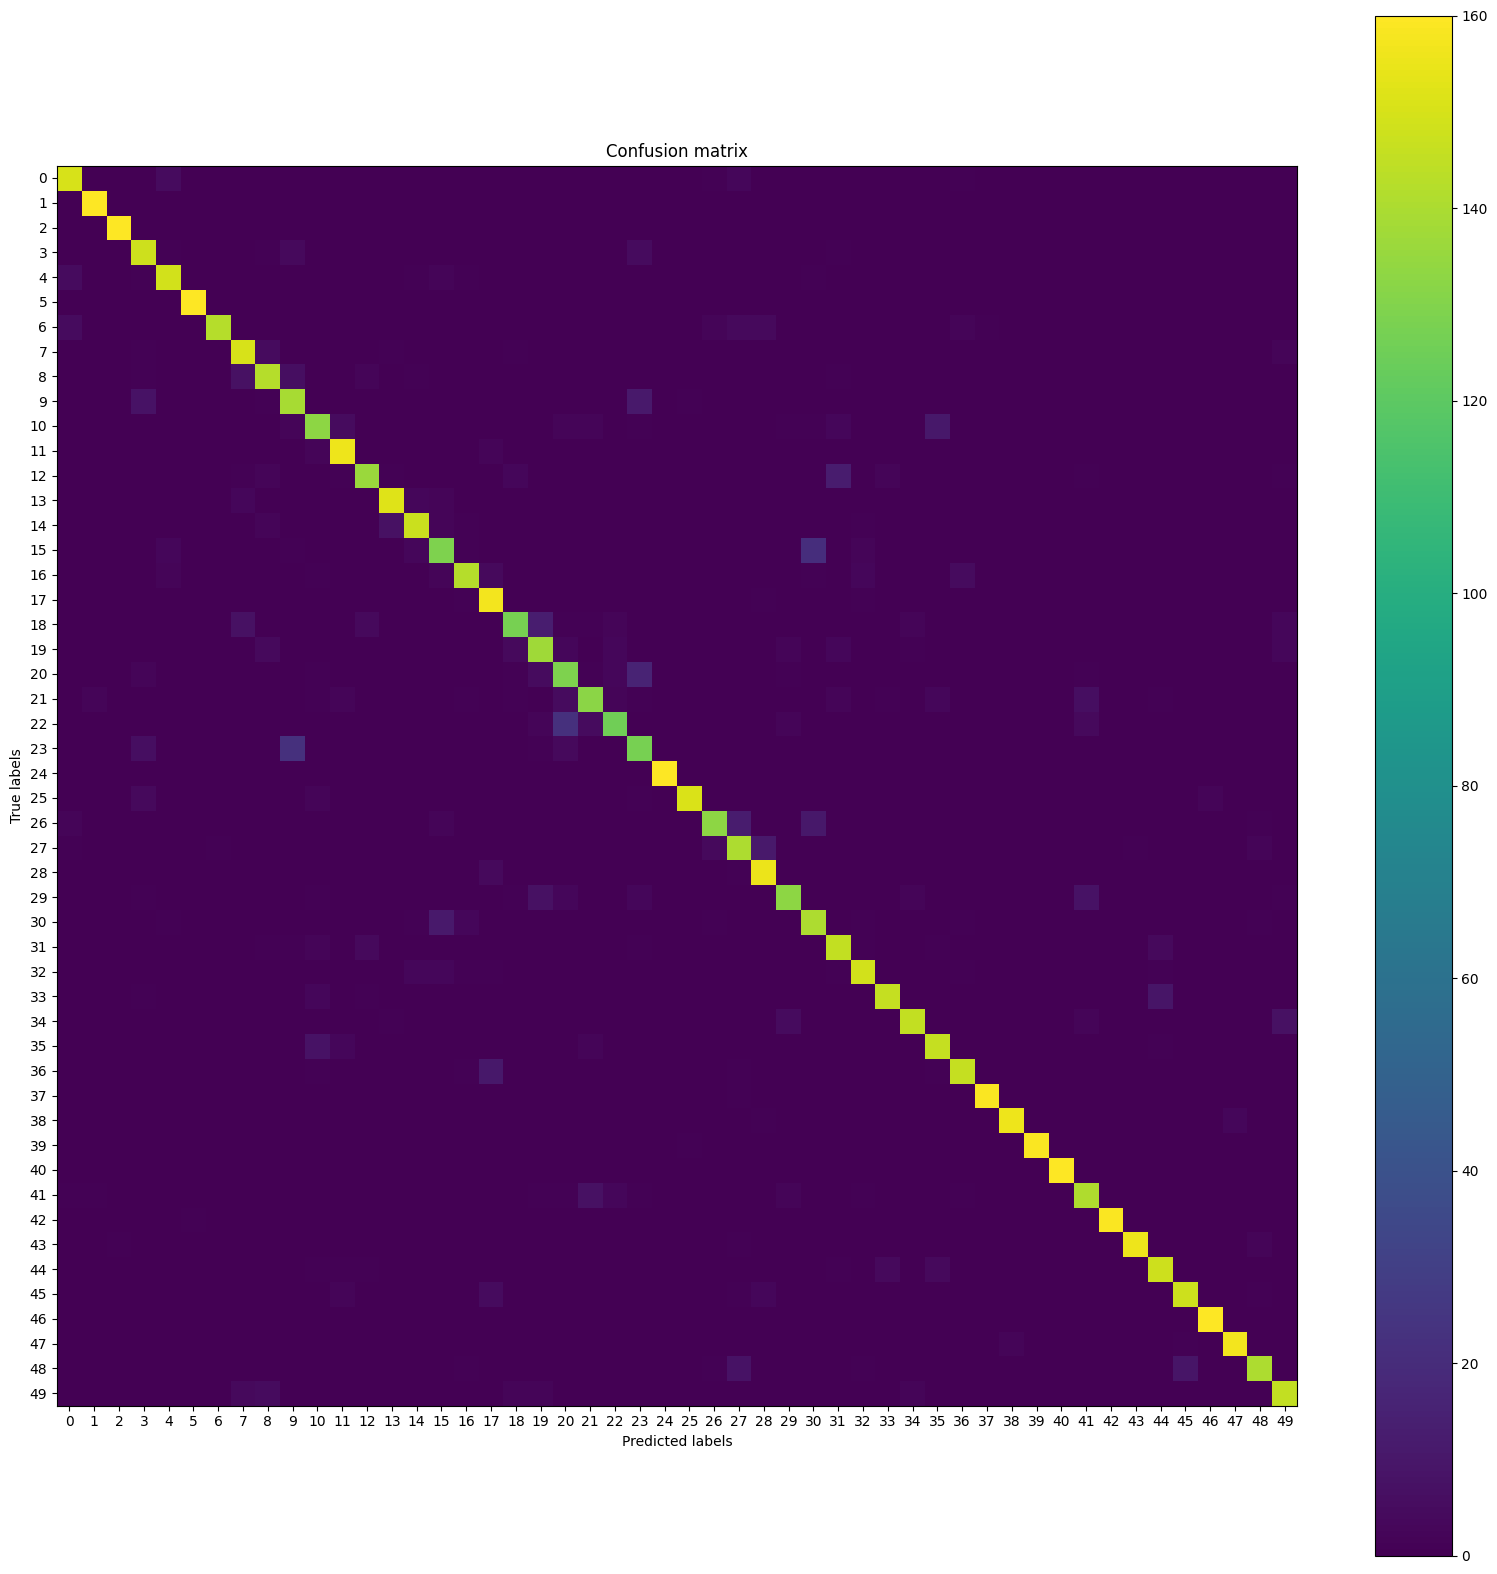

In [24]:
cm = confusion_matrix(Ytest, Ypred, labels=range(50))
# plot confusion matrix as an image
fig = plt.figure(figsize=(20, 20))
plt.imshow(cm)
plt.colorbar()
plt.yticks(range(0, 50, 1))
plt.xticks(range(0, 50, 1))
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion matrix")

Confusion Matrix with error percentage

In [25]:
cm = confusion_matrix(Ytest, Ypred)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/validation_loader.n))

True                 Predicted         	errors 	err % 
------------------------------------------------------------------
3046             ->  3003              	22 	0.28 % 
3045             ->  3039              	22 	0.28 % 
3022             ->  33909             	21 	0.26 % 
3039             ->  3046              	16 	0.20 % 
3037             ->  3038              	13 	0.16 % 
3068             ->  3069              	12 	0.15 % 
3010             ->  3622              	12 	0.15 % 
3003             ->  3046              	11 	0.14 % 
33909            ->  3022              	11 	0.14 % 
3069             ->  3070              	11 	0.14 % 
3004             ->  3700              	10 	0.12 % 
3794             ->  3024              	10 	0.12 % 
3068             ->  33909             	10 	0.12 % 
85984            ->  54200             	9 	0.11 % 
3659             ->  4490              	9 	0.11 % 
3298             ->  4286              	8 	0.10 % 
3700             ->  3004              	8 	0.10 %